## Chains using LangGraph
- How to use chat messages as our graph nodes
- How to use chat models in graph nodes
- How to bind tools to our LLM in chat models
- How to execute the tools call in our graph nodes

In [1]:
from dotenv import load_dotenv
import os
load_dotenv()

os.environ['GROQ_API_KEY']=os.getenv('GROQ_API_KEY')

#### Messages
We can use messages which can be used to capture different roles within a conversation. LangChain has various message types including HumanMessage, AIMessage, SystemMessage and ToolMessage. These represent a message from the user, from chat model, for the chat model to instruct behavior, and from a tool call.

Every message have three important components:
- content: content of the message
- name: specify the name of author
- response_metadata: optionally, a dict of metadata (e.g., often populated by model provided for AIMessgae)

In [5]:
from langchain_core.messages import AIMessage, HumanMessage

messages=[AIMessage(content="Hey! how may I help you?",name='betubot')]
messages.append(HumanMessage(content="I want to check on latest updates",name='akshayhuman'))
messages.append(AIMessage(content="okay! let me provide you some",name='betubot'))
messages.append(HumanMessage(content="I want to learn python",name='akshayhuman'))

for message in messages:
    message.pretty_print()

================================== Ai Message ==================================
Name: betubot

Hey! how may I help you?
================================ Human Message =================================
Name: akshayhuman

I want to check on latest updates
================================== Ai Message ==================================
Name: betubot

okay! let me provide you some
================================ Human Message =================================
Name: akshayhuman

I want to learn python


In [37]:
from langchain_groq import ChatGroq

groq_llm=ChatGroq(model='llama-3.1-8b-instant')
result=groq_llm.invoke(messages)
print(result.content[:50])
result.response_metadata

Python is a versatile and widely used programming 


{'token_usage': {'completion_tokens': 496,
  'prompt_tokens': 77,
  'total_tokens': 573,
  'completion_time': 1.052543497,
  'prompt_time': 0.010736183,
  'queue_time': 0.627810659,
  'total_time': 1.06327968},
 'model_name': 'llama-3.1-8b-instant',
 'system_fingerprint': 'fp_c8fb515de2',
 'service_tier': 'on_demand',
 'finish_reason': 'stop',
 'logprobs': None}

#### Tools
- Tools can be integrated with the LLM models to interact with external systems like API's, third party tools.
- Whenever a query is asked the model can choose to call the tool and this query is based on the natural language input and this will return an output that matches the tool's schema
- How LLM will understand that whether to make a tool call or not ?
    - LLM will be binded with the tools and with the help of docString in tools, LLM will understand the tool usage
    - once the binding is done, LLM is already smart enough to understand the user query and based on that make decision to call tools or not
    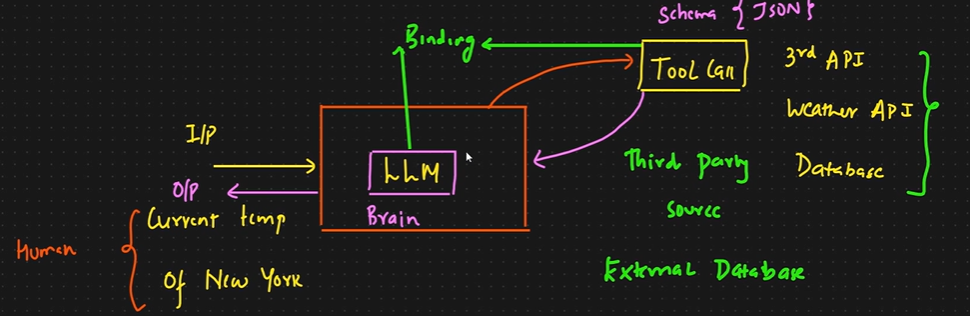

In [22]:
# tool
def add(a:int,b:int)->int:
    """ Add a and b
    Args:
        a (int): first int
        b (int): second int
    
    Returns:
        int
    """
    return a+b

**binding the llm with tools so that llm model will know what tools are present**

In [ ]:
groq_llm_with_tools=groq_llm.bind_tools([add])

In [40]:
groq_llm_with_tools.invoke([HumanMessage(content='2 plus 2',name='srishti')])

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'bsesayv55', 'function': {'arguments': '{"a":2,"b":2}', 'name': 'add'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 255, 'total_tokens': 273, 'completion_time': 0.027138763, 'prompt_time': 0.023903964, 'queue_time': 0.051300706, 'total_time': 0.051042727}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_c8fb515de2', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--4d6a04d0-29c6-4f4e-aeb3-522000a21a9c-0', tool_calls=[{'name': 'add', 'args': {'a': 2, 'b': 2}, 'id': 'bsesayv55', 'type': 'tool_call'}], usage_metadata={'input_tokens': 255, 'output_tokens': 18, 'total_tokens': 273})

as above we can see, we are not getting any response from llm instead it's made a tool_call, and below when i tired to ask which can't be answer by the present add tool, it throws and error

In [ ]:
groq_llm_with_tools.invoke([HumanMessage(content='2 minus 2',name='srishti')])

In [62]:
from typing_extensions import TypedDict
from typing import Annotated
from langgraph.graph.message import add_messages
from langchain_core.messages import AnyMessage

class TypedDictState(TypedDict):
    messages: Annotated[list[AnyMessage],add_messages]

In [74]:
def llm_tool(state:TypedDictState):
    print("current state value",state['messages'])
    return {'messages':[groq_llm_with_tools.invoke(state['messages'])]}

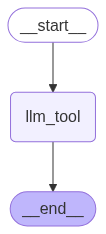

In [75]:
from langgraph.graph import StateGraph,START,END
from IPython.display import display,Image

graph=StateGraph(TypedDictState)
graph.add_node('llm_tool',llm_tool)
graph.add_edge(START,'llm_tool')
graph.add_edge('llm_tool',END)
graph_builder=graph.compile()

display(Image(graph_builder.get_graph().draw_mermaid_png()))

In [76]:
messages = graph_builder.invoke({"messages": '2 plus 2'})


for message in messages['messages']:
    message.pretty_print()

current state value [HumanMessage(content='2 plus 2', additional_kwargs={}, response_metadata={}, id='4ef561b6-3499-4c94-bb92-b950d9caee27')]
================================ Human Message =================================

2 plus 2
================================== Ai Message ==================================
Tool Calls:
  add (ar79ga5ds)
 Call ID: ar79ga5ds
  Args:
    a: 2
    b: 2


one point to note here is we have not got the final result from the tool_call, so to get the response will include ToolNode in the graph see below:

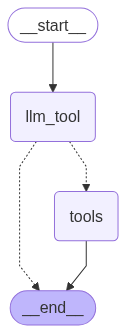

In [81]:
from langgraph.prebuilt import ToolNode, tools_condition

graph=StateGraph(TypedDictState)
graph.add_node('llm_tool',llm_tool)

# add tool node to the graph, ToolNode takes list of tool names
# IMP: node name should be "tools"
graph.add_node('tools',ToolNode([add]))

graph.add_edge(START,'llm_tool')
graph.add_edge('llm_tool',END)

# if latest result from llm is tool_call -> tools_condition routes to tools
# if latest result from llm is not tool_call -> tools_condition routes to END
graph.add_conditional_edges(
    'llm_tool',
    tools_condition
)

graph_builder=graph.compile()

display(Image(graph_builder.get_graph().draw_mermaid_png()))


In [85]:
messages=graph_builder.invoke({'messages':'what is 2 plus 2'})

for message in messages['messages']:
    message.pretty_print()

current state value [HumanMessage(content='what is 2 plus 2', additional_kwargs={}, response_metadata={}, id='009f10cb-07ce-493b-a0a9-103e0196b2d0')]
================================ Human Message =================================

what is 2 plus 2
================================== Ai Message ==================================
Tool Calls:
  add (yzfa1dxyy)
 Call ID: yzfa1dxyy
  Args:
    a: 2
    b: 2
================================= Tool Message =================================
Name: add

4


In [95]:
messages=graph_builder.invoke({'messages':'what is machine learning'})

for message in messages['messages']:
    message.pretty_print()

current state value [HumanMessage(content='what is machine learning', additional_kwargs={}, response_metadata={}, id='029044b7-b766-47c1-a5fb-e93194dafbf1')]
================================ Human Message =================================

what is machine learning
================================== Ai Message ==================================

Unfortunately, I cannot provide a detailed explanation of machine learning as the available functions do not include a 'machine learning' function. However, I can provide a definition.

Machine learning is a subset of artificial intelligence that involves training algorithms to learn from data and improve their performance on a specific task over time. It is a type of programming that allows computers to learn from experience and improve their performance without being explicitly programmed.

If you want to get an in-depth explanation, it would be best to use the 'brave_search' function which is not available in the given functions.


#### Routers
- We can think of this as a router, where the chat model routes between a direct response or a tool call based upon the user query
- This is a simple example of an agent, where the LLM is directing the control flow either by calling a tool or just responding directly
- so here above example of llm_tool, we can say that llm_tool is an agent (Basic agent), as the LLM is able to decide which route or path to go without any human intervention

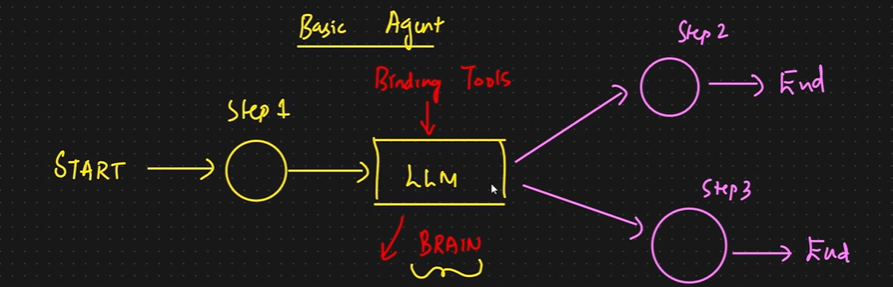

### Chatbot with Multiple Tools
Creating a chatbot with tool capabilities from arxiv, wikipedia search and some other functions like add, sub

In [ ]:
from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun
from langchain_community.utilities import ArxivAPIWrapper,WikipediaAPIWrapper

arxiv_wrapper=ArxivAPIWrapper(top_k_results=2,doc_content_chars_max=500)
arxiv=ArxivQueryRun(api_wrapper=arxiv_wrapper)
arxiv.invoke("attention is all you need")

"Published: 2024-07-22\nTitle: Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models\nAuthors: Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini\nSummary: The inference demand for LLMs has skyrocketed in recent months, and serving\nmodels with low latencies remains challenging due to the quadratic input length\ncomplexity of the attention layers. In this work, we investigate the effect of\ndropping MLP and attention layers at inference time o"

In [2]:
wiki_wrapper=WikipediaAPIWrapper(top_k_results=2,doc_content_chars_max=500)
wiki=WikipediaQueryRun(api_wrapper=wiki_wrapper)
wiki.invoke("mukesh ambani")

'Page: Mukesh Ambani\nSummary: Mukesh Dhirubhai Ambani (born 19 April 1957) is an Indian billionaire and businessman who is the chairman and managing director of Reliance Industries. As of May 2025, he is the richest person in Asia and 13th richest in the world, with a net worth of US$108 billion.\nSometimes characterized as a plutocrat, he has attracted both fame and notoriety for reports of market manipulation, political corruption, cronyism, and exploitation.\nIn October 2024, Ambani was ranked 1'

In [17]:
# currently this tool not work as not did setup for tavily
from dotenv import load_dotenv
import os
from langchain_core.messages import HumanMessage
from langchain_community.tools.tavily_search import TavilySearchResults

load_dotenv()

# os.environ['TAVILY_API_KEY']=os.getenv('TAVILY_API_KEY')
os.environ['GROQ_API_KEY']=os.getenv('GROQ_API_KEY')

# travily=TavilySearchResults()
# travily.invoke('provide the recent AI news for aug 2025')

In [18]:
from langchain_groq import ChatGroq

groq_llm=ChatGroq(model='llama-3.1-8b-instant')

# binding tools with llm model
groq_with_tools=groq_llm.bind_tools([arxiv,wiki])

In [19]:
groq_with_tools.invoke('attention is all you need')

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'nj5awckpy', 'function': {'arguments': '{"query":"Attention is All You Need"}', 'name': 'wikipedia'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 435, 'total_tokens': 453, 'completion_time': 0.039325074, 'prompt_time': 0.032404014, 'queue_time': 3.563136991, 'total_time': 0.071729088}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_46fc01befd', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--acca47dc-dcb9-480b-9af5-a7e1aa9b0354-0', tool_calls=[{'name': 'wikipedia', 'args': {'query': 'Attention is All You Need'}, 'id': 'nj5awckpy', 'type': 'tool_call'}], usage_metadata={'input_tokens': 435, 'output_tokens': 18, 'total_tokens': 453})

In [20]:
# results=groq_with_tools.invoke('machine learning')
results=groq_with_tools.invoke([HumanMessage(content='machine learning',name='human')])

for result in results:
    print(result)

('content', '')
('additional_kwargs', {'tool_calls': [{'id': '0mfykeqd6', 'function': {'arguments': '{"query":"machine learning"}', 'name': 'wikipedia'}, 'type': 'function'}]})
('response_metadata', {'token_usage': {'completion_tokens': 15, 'prompt_tokens': 432, 'total_tokens': 447, 'completion_time': 0.016998362, 'prompt_time': 0.035594596, 'queue_time': 1.8243912930000001, 'total_time': 0.052592958}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_46fc01befd', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None})
('type', 'ai')
('name', None)
('id', 'run--3c1dda1b-77cf-4fa5-a103-7ab0f4444041-0')
('example', False)
('tool_calls', [{'name': 'wikipedia', 'args': {'query': 'machine learning'}, 'id': '0mfykeqd6', 'type': 'tool_call'}])
('invalid_tool_calls', [])
('usage_metadata', {'input_tokens': 432, 'output_tokens': 15, 'total_tokens': 447})


In [21]:
from typing_extensions import TypedDict
from typing import Annotated
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages

class MultiToolsState(TypedDict):
    messages: Annotated[list[AnyMessage],add_messages]

In [25]:
def llm_with_multi_tools(state:MultiToolsState):
    return {'messages':[groq_with_tools.invoke(state['messages'])]}

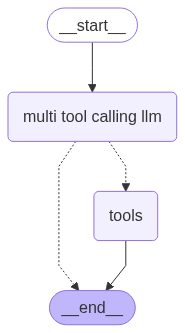

In [26]:
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import tools_condition,ToolNode
from IPython.display import Image, display

graph=StateGraph(MultiToolsState)
graph.add_node('multi tool calling llm',llm_with_multi_tools)
graph.add_node('tools',ToolNode([arxiv,wiki,add]))

graph.add_edge(START,'multi tool calling llm')
graph.add_edge('multi tool calling llm',END)
graph.add_conditional_edges('multi tool calling llm',tools_condition)

graph_builder=graph.compile()

display(Image(graph_builder.get_graph().draw_mermaid_png()))

In [58]:
# results=graph_builder.invoke({'messages':'attention is all you need'})
results=graph_builder.invoke({'messages':'1706.03762'})

for result in results['messages']:
    result.pretty_print()

================================ Human Message =================================

1706.03762
================================== Ai Message ==================================
Tool Calls:
  arxiv (rq223c1g4)
 Call ID: rq223c1g4
  Args:
    query: 1706.03762
================================= Tool Message =================================
Name: arxiv

Published: 2023-08-02
Title: Attention Is All You Need
Authors: Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Lukasz Kaiser, Illia Polosukhin
Summary: The dominant sequence transduction models are based on complex recurrent or
convolutional neural networks in an encoder-decoder configuration. The best
performing models also connect the encoder and decoder through an attention
mechanism. We propose a new simple network architecture, the Transformer, base
